# **Dementia Patients -- Analysis and Prediction**
### ***Author : Akhilesh Vyas***
### ****Date : May, 2020****

- <a href='#00'>0. Setup </a>
    - <a href='#00.1'>0.1. Load libraries </a>
    - <a href='#00.2'>0.2. Define paths </a>

- <a href='#01'>1. Data Cleaning and Preprocessing </a>  
    
- <a href='#02'>2. Deep Neural Network Model</a>

- <a href='#03'>3. Result Analysis</a> 

# <a id='00'>0. Setup </a>

## <a id='#00.1'>0.1. Load libraries </a>

In [8]:
import torch
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split

import pickle

/Volumes/Vyas-HD/programming/python3Env/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


## <a id='#00.2'>0.2. Define paths </a>

In [2]:
data_path = '../../data/'

# <a id='#01'>1. Data Cleaning and Preprocessing </a>

In [3]:
patient_df = pd.read_csv(data_path+'patient_df_rnn.csv')

#print (patient_df.isna().sum()/patient_df.shape[0])
patient_df = patient_df.loc[:, patient_df.isna().sum()/patient_df.shape[0]< 0.4]

patient_df['patient_index'] = patient_df.index
patient_ids = patient_df['patient_id']
patient_eps = patient_df['EPISODE_DATE']

patient_df = patient_df.drop(columns=['EPISODE_DATE', 'MINI_MENTAL_SCORE_PRE'])
patient_df = patient_df.groupby(by='patient_id').transform(lambda x: x.interpolate(method='ffill'))

patient_df['EPISODE_DATE'] = patient_eps
patient_df['patient_id'] = patient_ids

patient_df = patient_df.loc[:, patient_df.isna().sum()/patient_df.shape[0]< 0.2]

patient_df = patient_df.iloc[:, [-1,-2,-3]+ [i for i in range(0, len(patient_df.columns)-3)]]

patient_df = patient_df.fillna(-1)
patient_df.head(5)

,patient_id,EPISODE_DATE,patient_index,MINI_MENTAL_SCORE,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SCALES,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SUITCASE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_BAROMETER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_LAMP,COGNITIVE_EXAM_120-161:_(147)_RECOGNISES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(147)_RECOGNISES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(147)_RECOGNISES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(148)_REMEMBERS_WW1_DATE,COGNITIVE_EXAM_120-161:_(149)_REMEMBERS_WW2_DATE,COGNITIVE_EXAM_120-161:_(150)_REMEMBERS_HITLER,COGNITIVE_EXAM_120-161:_(151)_REMEMBERS_STALIN,COGNITIVE_EXAM_120-161:_(152)_REMEMBERS_MAE_WEST,COGNITIVE_EXAM_120-161:_(153)_REMEMBERS_LINDBERGH,COGNITIVE_EXAM_120-161:_(154)_KNOWS_MONARCH,COGNITIVE_EXAM_120-161:_(155)_KNOWS_HEIR_TO_THRONE,COGNITIVE_EXAM_120-161:_(156)_KNOWS_PRIME_MINISTER,COGNITIVE_EXAM_120-161:_(157)_KNOWS_RECENT_NEWS_ITEM,COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS,COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS_1:_APPLE,COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS_3:_PENNY,COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS:_REPEATS,COGNITIVE_EXAM_120-161:_(159)_COUNTING_BACKWARDS,COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS_1:_APPLE,COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS_2:_TABLE,COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS_3:_PENNY,COGNITIVE_EXAM_162-187:_COGNITIVE_EXAM_16

In [4]:
# embedding Matrix
embedding_weight = torch.from_numpy(patient_df.iloc[:, 4:].values).float()
# embedding_weight = F.normalize(torch.from_numpy(patient_df.iloc[:, 4:].values).float(), p=2, dim=1, eps=1e-12, out=None)
print(embedding_weight.shape)
# pairs 
patient_indx_MMS = patient_df.groupby(['patient_id'])['patient_index', 'MINI_MENTAL_SCORE'].agg(lambda x : x.tolist())
patient_indx_MMS['count'] = patient_indx_MMS['patient_index'].apply(lambda x: len(x))


torch.Size([6511, 171])


/nfs/home/vyasa/software/pkg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


# <a id='#02'>2. Deep Neural Network Model</a>

In [5]:
MAX_LENGTH = 10
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print (device)

cuda


In [6]:
pid_list = patient_indx_MMS['patient_index'].values
mmse_list = patient_indx_MMS['MINI_MENTAL_SCORE'].values
pairs = [[pid, mmse] if len(pid) <= 10 else [pid[0:10], mmse[0:10]] for pid, mmse  in zip(pid_list,mmse_list)]
pairs[0:10]

def tensorsFromPair(pair):
    input_tensor = torch.tensor(pair[0], dtype=torch.long, device=device).view(-1, 1)
    target_tensor = torch.tensor(pair[1], dtype=torch.float, device=device).view(-1, 1)
    return (input_tensor, target_tensor)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points1, points2):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=5)
    ax.yaxis.set_major_locator(loc)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.plot(points1, label='train')
    plt.plot(points2, label='val')
    ax.legend()
    plt.savefig('train_val.png')


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_weight, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        #self.dropout = dropout
        self.embedding = nn.Embedding.from_pretrained(embedding_weight)
        #self.embedding_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        #output = self.embedding_dropout(output)
        # print(output.dtype, hidden.dtype)
        # output = F.relu(output) # May be not converging due to this 
        # print(output.dtype, hidden.dtype)
        output, hidden = self.lstm(output, hidden)
        #print (output)
        output = self.out(output[0])
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

In [8]:
def train(input_tensor, target_tensor, lstm_model, lstm_model_optimizer, criterion):
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    lstm_model_optimizer.zero_grad()
    lstm_model_hidden = lstm_model.initHidden()
    input_length = input_tensor.size(0)
    loss = 0

    for di in range(input_length):
        # print (input_tensor[di].dtype, lstm_model_hidden.dtype)
        lstm_model_output, lstm_model_hidden  = lstm_model(
            input_tensor[di], lstm_model_hidden)
        #print (lstm_model_output.dtype, target_tensor[di].dtype)
        #print (lstm_model_output, target_tensor[di])
        loss += criterion(lstm_model_output[0], target_tensor[di])
        #print (loss.requires_grad)
        #print ('train:',loss.dtype)
    
    loss.backward()
    lstm_model_optimizer.step()

    return loss.item() / input_length

def evalu(input_tensor, target_tensor, lstm_model, criterion):
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        lstm_model_hidden = lstm_model.initHidden()
        input_length = input_tensor.size(0)
        loss = 0
        output = []
        o_act = []
        o_pre = []
        for di in range(input_length):
            # print (input_tensor[di].dtype, lstm_model_hidden.dtype)
            lstm_model_output, lstm_model_hidden  = lstm_model(
                input_tensor[di], lstm_model_hidden)
            #print (lstm_model_output.dtype, target_tensor[di].dtype)
            #print (lstm_model_output, target_tensor[di])
            loss += criterion(lstm_model_output[0], target_tensor[di])
            o_pre.append(lstm_model_output[0].cpu().numpy().tolist()[0])
            o_act.append(target_tensor[di][0].cpu().numpy().tolist())
            #print (loss.requires_grad)
            #print ('train:',loss.dtype)
        output.append((o_act,o_pre))
    return (loss.item() / input_length, output)

In [9]:
def trainIters(lstm_model, n_iters, print_every=100, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    plot_loss_val = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    lstm_model_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    
    train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
    
    print (len(train_pairs), len(val_pairs))
    
    training_pairs = [tensorsFromPair(random.choice(train_pairs))
                      for i in range(n_iters)]
    
    validation_pairs = [tensorsFromPair(random.choice(val_pairs))
                      for i in range(len(val_pairs))]
    
    # need to define loss function
    criterion = nn.MSELoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, lstm_model,
                     lstm_model_optimizer, criterion)
        
        #print ('trainIters:',loss.dtype)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            total_val_loss = 0
            lstm_model.eval()
            output_total = []
            for i in range(0, len(validation_pairs)):
                input_tensor = validation_pairs[i][0]
                target_tensor = validation_pairs[i][1]
                loss1, output = evalu(input_tensor, target_tensor, lstm_model,criterion)
                total_val_loss+=loss1
                output_total.append(output)
            print_val_loss_avg = total_val_loss / len(validation_pairs)
            
            print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, print_val_loss_avg))
            
            plot_loss_val.append(print_val_loss_avg)
            
            lstm_model.train()      

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            
    return (plot_losses, plot_loss_val, output_total)


In [10]:
hidden_size = 171
output_size = 1

lstm_model = LSTMModel(hidden_size, output_size, embedding_weight, dropout=0.0).to(device)
#trainIters(lstm_model, 3, print_every=1)
plot_losses, plot_loss_val, output_total = trainIters(lstm_model, 50000, print_every=1000, plot_every=1000)

822 206
0m 11s (- 9m 47s) (1000 2%) 85.8773 34.8103
0m 21s (- 8m 30s) (2000 4%) 26.3482 24.5766
0m 30s (- 8m 0s) (3000 6%) 20.3375 21.3665
0m 40s (- 7m 40s) (4000 8%) 17.7902 21.0738
0m 49s (- 7m 22s) (5000 10%) 14.9931 17.1672
0m 58s (- 7m 6s) (6000 12%) 12.1452 18.6828
1m 7s (- 6m 53s) (7000 14%) 15.1405 15.4489
1m 16s (- 6m 41s) (8000 16%) 10.9546 15.3063
1m 25s (- 6m 30s) (9000 18%) 11.8666 13.1339
1m 34s (- 6m 18s) (10000 20%) 12.0234 14.8932
1m 43s (- 6m 7s) (11000 22%) 9.9833 15.9858
1m 52s (- 5m 57s) (12000 24%) 9.6601 13.9333
2m 1s (- 5m 47s) (13000 26%) 8.3177 13.0683
2m 10s (- 5m 36s) (14000 28%) 8.7050 14.3121
2m 20s (- 5m 26s) (15000 30%) 10.2851 13.3102
2m 29s (- 5m 17s) (16000 32%) 8.2586 13.9928
2m 38s (- 5m 7s) (17000 34%) 7.0819 13.2421
2m 47s (- 4m 57s) (18000 36%) 10.9615 13.1605
2m 56s (- 4m 47s) (19000 38%) 9.5403 12.7959
3m 5s (- 4m 38s) (20000 40%) 7.9133 14.5726
3m 15s (- 4m 29s) (21000 42%) 6.3295 13.8188
3m 24s (- 4m 20s) (22000 44%) 7.0324 11.7010
3m 33s (- 

<Figure size 432x288 with 0 Axes>

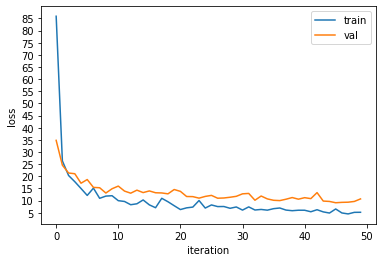

In [11]:
showPlot(plot_losses, plot_loss_val)

# <a id='#03'>3. Result Analysis</a>

In [7]:
with open('output_total.pkl', 'wb') as f:
    pickle.dump(output_total, f)
    
with open('output_total.pkl', 'rb') as f:
    pkkk = pickle.load(f)

NameError: name 'output_total' is not defined

In [11]:
def readpicklefile(file):
    with open(file, 'rb') as f:
        file_obj = pickle.load(f)
    return file_obj

In [13]:
def listgen(pkkk):
    lnth = len(pkkk)
    i = 0
    while i < lnth:
        yield pkkk[i]
        i +=1
        
act_l = []
prd_l = []
for i,j in enumerate(listgen(pkkk)):
    for k,l in zip(j[0][0], j[0][1]):
        act_l.append(k)
        prd_l.append(l)

In [14]:
def plot_hist(diff_act_prd):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(diff_act_prd, label='Absolute difference between True and Predicted MMSE Value')
    ax.set_title('Histogram absolute difference between True and Predicted MMSE Value')
    plt.ylabel('count')
    plt.xlabel('value')
    plt.show()
    fig.savefig('abs_pre_true.jpeg')

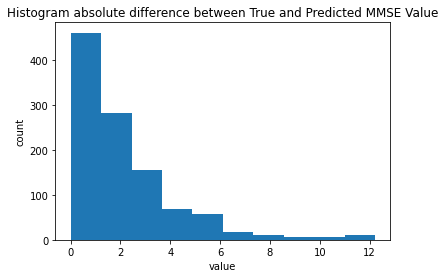

In [15]:
plot_hist(diff_act_prd)